# Bayesian Regression

In this notebook we are going to continue our modelling of field goals, but instead of using a frequentist maximum likelihood approach we shall shift to a Bayesian statistical framework. The data we will be training on are from the 2018 and 2019 seasons of the NFL. We previously trained on pre-2017 data, to line up with the exisiting studies. We did this to show that there are interactions happening in those years that were not accounted for. Let's get started in updating our model for the latest seasons.

In [2]:
import sys
sys.path.append('C:\\Users\\Lewis.Bails\\Repositories\\nfl_study')

In [3]:
from util.stats import summary
import pymc3 as pm
import pandas as pd
import mysql.connector
import pickle

In [4]:
cnx = mysql.connector.connect(user='root', password='mOntie20!mysql', host='127.0.0.1', database='nfl')

base_query = '''select
p.pid,fg.good,fg.dist, 
g.seas as year, k.seas as seasons,
case when g.temp<50 then 1 else 0 end as cold,
case when g.stad like "%Mile High%" then 1 else 0 end as altitude,
case when g.humd>=60 then 1 else 0 end as humid,
case when g.wspd>=10 then 1 else 0 end as windy,
case when g.v=p.off then 1 else 0 end as away_game,
case when g.wk>=10 then 1 else 0 end as postseason,
case when (pp.qtr=p.qtr) and ((pp.timd-p.timd)>0 or (pp.timo-p.timo)>0) then 1 else 0 end as iced,
case g.surf when 'Grass' then 0 else 1 end as turf,
case when g.cond like "%Snow%" then 1 when g.cond like "%Rain%" and not "Chance Rain" then 1 else 0 end as precipitation,
case when p.qtr=4 and ABS(p.ptso - p.ptsd)>21 then 0
when p.qtr=4 and p.min<2 and ABS(p.ptso - p.ptsd)>8 then 0
when p.qtr=4 and p.min<2 and p.ptso-p.ptsd < -7 then 0
when p.qtr<=3 then 0
when p.qtr=4 and p.min>=2 and ABS(p.ptso - p.ptsd)<21 then 0
when p.qtr=4 and p.min<2 and p.ptso-p.ptsd >=5 and p.ptso-p.ptsd <=8 then 0
when p.qtr=4 and p.min<2 and p.ptso-p.ptsd >=-4 and p.ptso-p.ptsd <=-6 then 0
else 1 end as pressure'''

query = base_query+'''
from FGXP fg
left join PLAY p on fg.pid=p.pid
left join game g on p.gid=g.gid
join kicker k on k.player = fg.fkicker and g.gid=k.gid
join PLAY pp on pp.pid=p.pid-1 and pp.gid=p.gid
where fg.fgxp='FG' -- not an xp
and g.seas >2017
order by p.pid
'''

df = pd.read_sql(query, cnx, index_col = 'pid')
df['cold*windy'] = df['cold']*df['windy']
df['postseason*away_game'] = df['postseason']*df['away_game']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2007 entries, 785567 to 873152
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   good                  2007 non-null   int64
 1   dist                  2007 non-null   int64
 2   year                  2007 non-null   int64
 3   seasons               2007 non-null   int64
 4   cold                  2007 non-null   int64
 5   altitude              2007 non-null   int64
 6   humid                 2007 non-null   int64
 7   windy                 2007 non-null   int64
 8   away_game             2007 non-null   int64
 9   postseason            2007 non-null   int64
 10  iced                  2007 non-null   int64
 11  turf                  2007 non-null   int64
 12  precipitation         2007 non-null   int64
 13  pressure              2007 non-null   int64
 14  cold*windy            2007 non-null   int64
 15  postseason*away_game  2007 non-null   int64
dtyp

In [5]:
exp_results = pd.read_csv('expanded_results.csv', index_col=0).rename(index={'cold:windy':'cold*windy', 'postseason:away_game':'postseason*away_game'})
exp_results

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-88.3109,8.221,-10.741,0.000,-104.425,-72.197
dist,-0.1054,0.002,-42.272,0.000,-0.110,-0.101
year,0.0468,0.004,11.401,0.000,0.039,0.055
seasons,0.0173,0.004,4.163,0.000,0.009,0.025
cold,-0.1208,0.055,-2.200,0.028,-0.228,-0.013
altitude,0.3854,0.125,3.072,0.002,0.140,0.631
humid,-0.0751,0.046,-1.621,0.105,-0.166,0.016
windy,-0.0667,0.058,-1.152,0.249,-0.180,0.047
away_game,0.0664,0.060,1.110,0.267,-0.051,0.184
postseason,0.0672,0.062,1.092,0.275,-0.053,0.188


In [7]:
priors = {}
for cov,data in exp_results.iterrows():
        print(cov, data['coef'], data['std err']*2)
        priors[cov] = pm.Normal.dist(data['coef'], data['std err']*2)

Intercept -88.3109 16.442
dist -0.1054 0.004
year 0.0468 0.008
seasons 0.0173 0.008
cold -0.1208 0.11
altitude 0.3854 0.25
humid -0.0751 0.092
windy -0.0667 0.116
away_game 0.0664 0.12
postseason 0.0672 0.124
iced -0.1316 0.124
turf 0.2431 0.092
precipitation -0.1902 0.15
pressure -0.0135 0.17600000000000002
cold*windy -0.3488 0.19
postseason*away_game -0.1884 0.168


In [8]:
# formula
formula = 'good ~ '+'+'.join(df.drop('good', axis=1).columns.values)
print(formula)

good ~ dist+year+seasons+cold+altitude+humid+windy+away_game+postseason+iced+turf+precipitation+pressure+cold*windy+postseason*away_game


In [10]:
with pm.Model() as logistic_model:

    # shared variable
    df_shared = pm.Data('data', df)

    # model
    pm.glm.GLM.from_formula(formula,
                            df_shared,
                            priors=priors,
                            family=pm.glm.families.Binomial())
    
    # trace
    trace = pm.sample(100, tune=100, init='adapt_diag')

    # save model
    with open('logistic_model.pkl', 'wb') as f:
        pickle.dump(logistic_model, f)

    # save trace
    with open('trace.pkl', 'wb') as f:
        pickle.dump(trace, f)


What about when it comes to prediction time? We sample from the posteriors however many times, replace the shared dataframe in the glm object, and predict.

In [1]:
with open('logistic_model.pkl', 'rb') as f:
    with open('trace.pkl', 'rb') as g:
        model = pickle.load(f)
        trace = pickle.load(g)

        

FileNotFoundError: [Errno 2] No such file or directory: 'logistic_model.pkl'

In [ ]:
with model:
    new_data = df.drop('good', axis=1).iloc[:-10,:] # drop good?
    model.set_data({'data':new_data})
    y_test = pm.sample_posterior_predictive(trace)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A23D3D5FC8>,
      dtype=object)

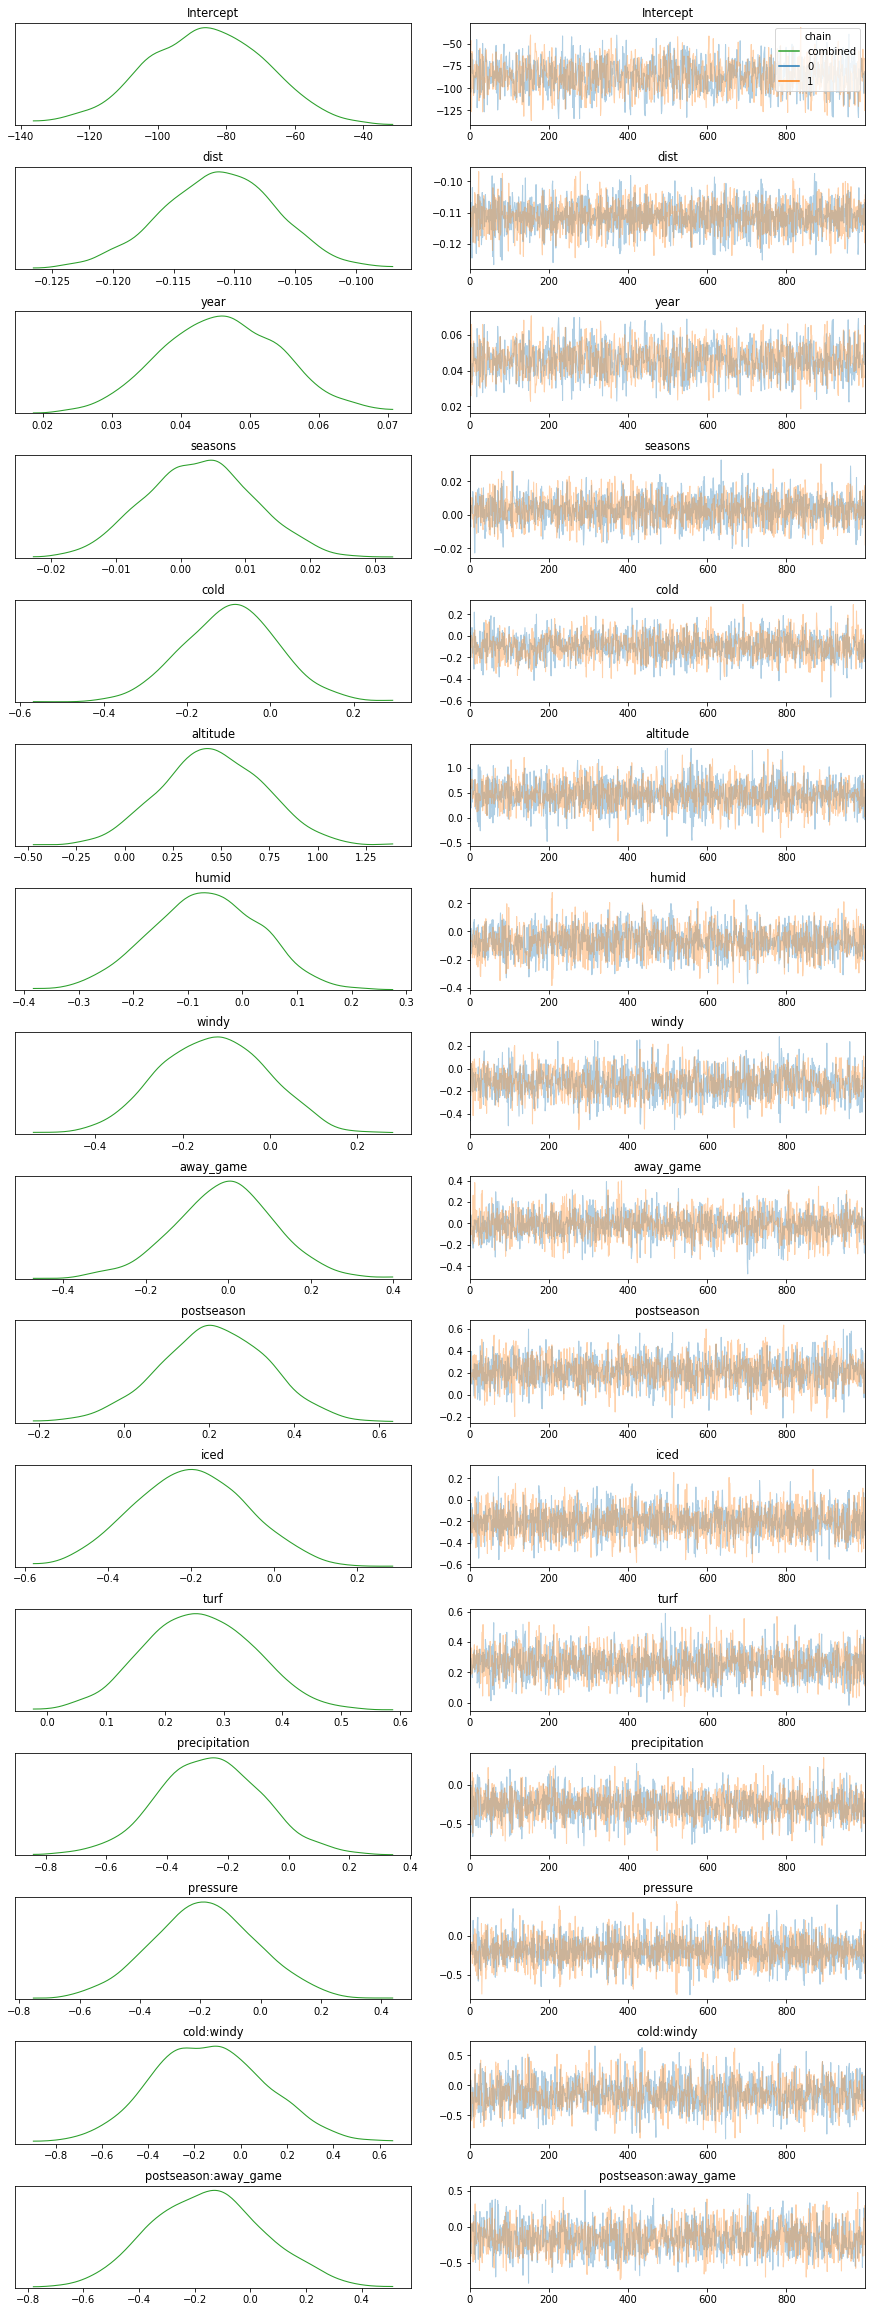

In [14]:
pm.traceplot(trace, legend=True, combined=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002EC76AA3088>,
      dtype=object)

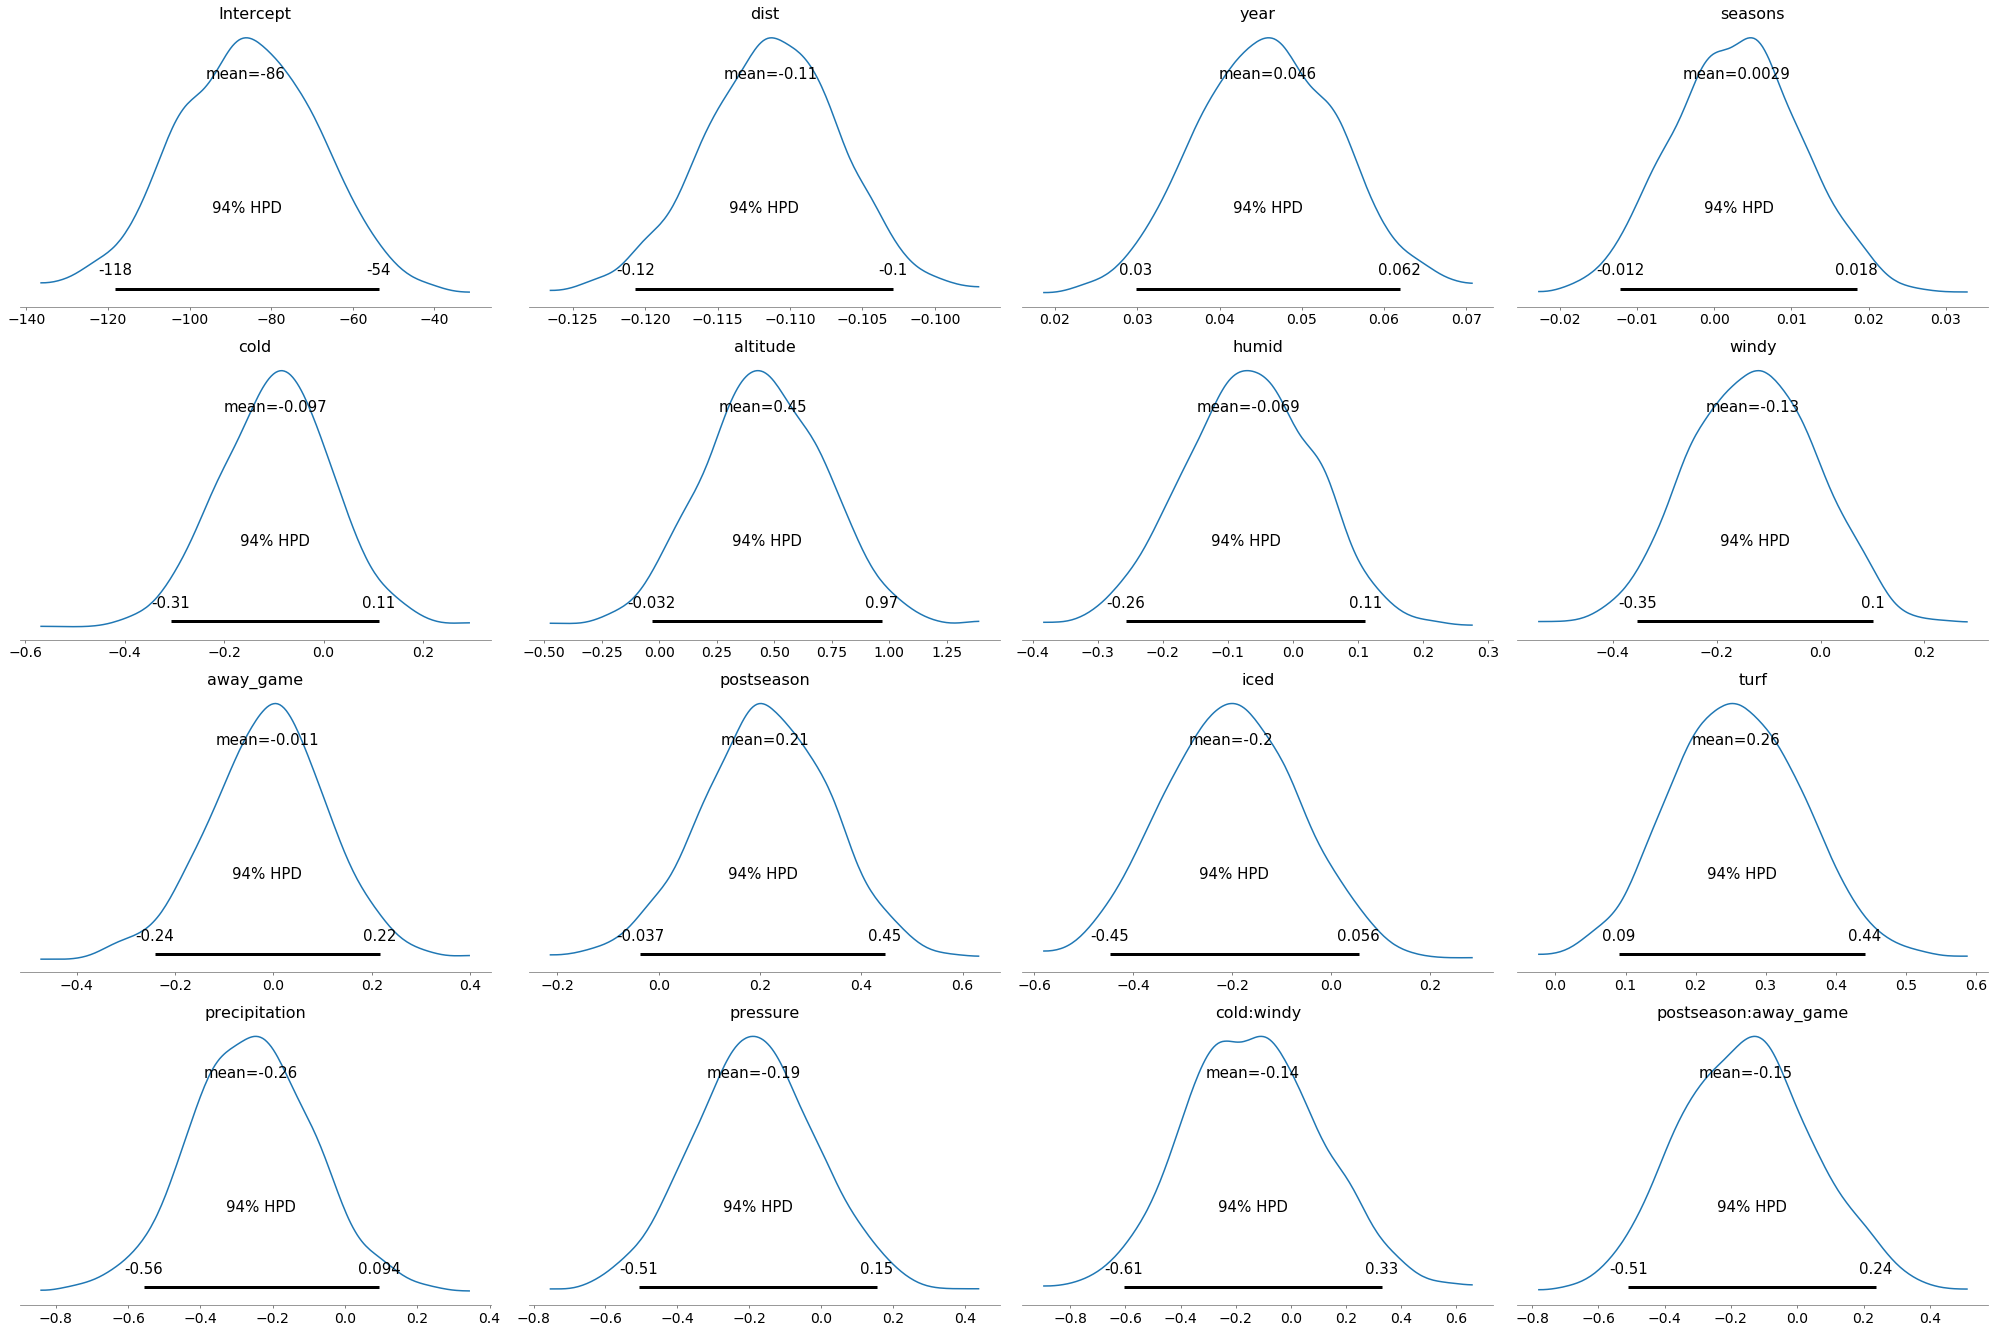

In [3]:
pm.plot_posterior(trace)

In [3]:


with open('trace_1702.pkl', 'rb') as f:
    trace = pickle.load(f)
    summary_ = summary(trace)

In [5]:
summary_

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,-86.332265,17.316415,0.391770,-117.941969,-50.414928,1661.939311,0.999602
dist,-0.111337,0.004751,0.000075,-0.121093,-0.102593,3890.483997,0.999516
year,0.045849,0.008581,0.000194,0.027941,0.061457,1662.170301,0.999602
seasons,0.002873,0.008271,0.000158,-0.012178,0.019417,2743.135515,0.999782
cold,-0.096576,0.111820,0.002587,-0.308943,0.128379,1957.111036,0.999579
altitude,0.453272,0.271196,0.005648,-0.072555,0.971803,2254.430588,0.999690
humid,-0.068773,0.099294,0.002162,-0.266324,0.114188,2309.384976,0.999511
windy,-0.131461,0.125486,0.002903,-0.357371,0.110923,1709.189479,0.999777
away_game,-0.011036,0.120325,0.002784,-0.241100,0.236754,2167.811714,0.999535
postseason,0.208900,0.128886,0.003118,-0.061105,0.446172,2007.414421,0.999722


In [4]:
import pymc3 as pm
pm.__version__
formula = 'good ~ '+'+'.join(df.drop('good', axis=1).columns.values)
print(formula)
priors = {}
for cov,data in exp_results.iterrows():
    print(cov, data['coef'], data['std err']*3)
    priors[cov] = pm.Normal.dist(data['coef'], data['std err']*2)

glm_model = pm.glm.GLM.from_formula(formula,
                            theano.shared(df.values),
                            priors=priors,
                            family=pm.glm.families.Binomial())
print(glm_model.__dict__)


good ~ dist+year+seasons+cold+altitude+humid+windy+away_game+postseason+iced+turf+precipitation+pressure+cold*windy+postseason*away_game
Intercept -88.3109 24.663
dist -0.1054 0.006
year 0.0468 0.012
seasons 0.0173 0.012
cold -0.1208 0.165
altitude 0.3854 0.375
humid -0.0751 0.138
windy -0.0667 0.17400000000000002
away_game 0.0664 0.18
postseason 0.0672 0.186
iced -0.1316 0.186
turf 0.2431 0.138
precipitation -0.1902 0.22499999999999998
pressure -0.0135 0.264
cold*windy -0.3488 0.28500000000000003
postseason*away_game -0.1884 0.252
